<div style="width: 100%; margin: 0; padding: 20px; font-family: Georgia, 'Times New Roman', Times, serif; background-color: #ffffff; color: #333333; border-bottom: 1px solid #dcdcdc;">
  <!-- Project Title -->
  <h1 style="font-size: 1.2em; margin-bottom: 0.2em; color: #000000;">
    BUAN6342.501: Individual Project
  </h1>
  <h1 style="font-size: 2.0em; margin-bottom: 0.2em; color: #000000;">
    Automatic Text Summarization System
  </h1>
  
  <!-- Project Description -->
  <p style="font-size: 1.125em; line-height: 1.6;">
    <br>
    This notebook implements an automatic text summarization system in two parts:
    <br><br>
    <strong>Part One:</strong> Uses NLTK for preprocessing, POS tagging, Named Entity Recognition (NER), vectorization, and summarization using a TextRank-like algorithm.
    <br>
    <strong>Part Two:</strong> Leverages spaCy (with scikit-learn) for similar tasks alongside a text classification pipeline.
    <br><br>
    <strong>Final Outputs:</strong> Two side-by-side grids display each approach's top 10 news headlines summary for easy comparison.
  </p>
  
  <!-- Author Information -->
  <p style="font-size: 1em; font-weight: bold; color: #a51c30; margin-top: 20px;">
    Author: Ashlesha Sanjay Kadam.
  </p>
</div>

<h3 style="font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
           font-size: 1.25em;
           color: #000000;
           font-weight: bold;
           border-bottom: 1.5px solid #dcdcdc;
           margin-top: 20px;
           margin-bottom: 10px;
           padding-bottom: 5px;">
  Part One: NLTK Implementation
</h3>

In [187]:
# Step 1: Import Required Libraries
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download required NLTK data (only needed on first run)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

In [203]:
# Step 2: Load the Data
df = pd.read_csv("headlines.csv")
if 'headline' in df.columns:
    original_headlines = df['headline'].astype(str).tolist()
else:
    original_headlines = df.iloc[:, 0].astype(str).tolist()

In [204]:
# Step 3: Preprocess Headlines using NLTK
def nltk_preprocess(text):
    """
    Preprocess text using NLTK:
      - Lowercasing
      - Tokenization
      - Removal of punctuation and stop words
      - Stemming and lemmatization
    """
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed = [stemmer.stem(token) for token in tokens]
    lemmatized = [lemmatizer.lemmatize(token) for token in stemmed]
    return " ".join(lemmatized)

nltk_processed = [nltk_preprocess(headline) for headline in original_headlines]

In [205]:
# Step 4: POS Tagging and NER using NLTK (Demonstration on the first headline)
def nltk_pos_ner(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    named_entities = nltk.ne_chunk(pos_tags, binary=False)
    return pos_tags, named_entities

example_pos_tags, example_ne_tree = nltk_pos_ner(original_headlines[0])
print("NLTK POS Tags (Example):", example_pos_tags)
print("NLTK Named Entities (Example):", example_ne_tree)

NLTK POS Tags (Example): [('For', 'IN'), ('Some', 'DT'), (',', ','), ('The', 'DT'), ('Decision', 'NNP'), ('To', 'TO'), ('Enlist', 'VB'), ('Offers', 'NNP'), ('Direction', 'NNP')]
NLTK Named Entities (Example): (S
  For/IN
  Some/DT
  ,/,
  The/DT
  Decision/NNP
  To/TO
  Enlist/VB
  (PERSON Offers/NNP Direction/NNP))


In [206]:
# Step 5: Text Vectorization (CountVectorizer and TF-IDF) using NLTK-Processed Data
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(nltk_processed)
print("\nCountVectorizer shape:", X_count.shape)

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(nltk_processed)
print("TF-IDF Vectorizer shape:", X_tfidf.shape)


CountVectorizer shape: (9998, 7883)
TF-IDF Vectorizer shape: (9998, 7883)


In [207]:
# TextRank-like Summarization

def text_rank_summarize(processed_texts, original_texts, top_n=10):
    """
    Generate a summary by computing TF-IDF based similarity, applying PageRank,
    and selecting the top_n headlines. The ranking is based on the preprocessed texts,
    but the original texts are returned.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_texts)
    
    # Compute cosine similarity matrix
    similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
    
    # Create graph and apply PageRank
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)
    
    ranked = sorted(((score, idx) for idx, score in scores.items()), reverse=True)
    selected_indices = sorted([idx for (_, idx) in ranked[:top_n]])
    summary = [original_texts[i] for i in selected_indices]
    return summary

In [208]:
# Step 5: Summarize Headlines
nltk_summary = text_rank_summarize(nltk_processed, original_headlines, top_n=10)

In [209]:
print("\nNLTK-based Summary:")
for i, sentence in enumerate(nltk_summary, 1):
    print(f"{i}. {sentence}")


NLTK-based Summary:
1. Clinton, Obama Attack Health Care Plans
2. Obama Says Gadhafi 'Must Leave' Power In Libya
3. ElBaradei Back In Egypt; Says It's Time For A New Government
4. New California Law Says Police Should Kill Only When 'Necessary'
5. Tax Deal Draws Fire; Obama Says It's Needed
6. Trump Says He Called Off Strike On Iran Because He Didn't See It As 'Proportionate'
7. Obama Gives New Details On America's Effort To Fight Ebola
8. Obama Gives New Details On America's Effort To Fight Ebola
9. What Obama Should Say And Do About Ebola
10. Iran Says Trump's New Sanctions Have Ended Diplomacy


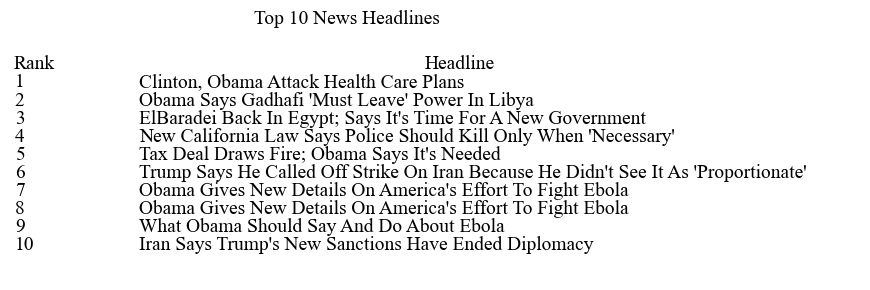

In [210]:
import matplotlib.pyplot as plt

def display_top_headlines_nyt_style(headlines, title="Top 10 News Headlines"):
    """
    Display a minimalist, data-driven table with minimal whitespace.
    
    :param headlines: List of headline strings (assumed sorted by importance).
    :param title:     Title for the table/figure.
    """

    # Prepare table data: each row is [rank, headline]
    table_data = [[str(i), headline] for i, headline in enumerate(headlines, start=1)]

    # Make the figure height scale a bit with the number of headlines
    # Adjust these multipliers as needed
    fig_height = 0.15 * len(headlines) + 1.5
    fig_width = 7  # narrower figure
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Remove axis lines and ticks
    ax.axis('off')
    
    # Create the table, letting matplotlib auto-size columns
    table = ax.table(
        cellText=table_data,
        colLabels=["Rank", "Headline"],
        loc='center',
        cellLoc='left'
    )
    
    # Auto-size columns to fit data
    table.auto_set_column_width(col=list(range(2)))
    
    # Control font size and remove any extra vertical scaling
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    # Style each cell
    for (row, col), cell in table.get_celld().items():
        # Remove borders
        cell.set_edgecolor('none')
        cell.set_linewidth(1)
        # White background
        cell.set_facecolor('white')
        
        if row == 0:
            # Header row: normal weight, align with data
            cell.set_text_props(fontweight='normal')
            cell._loc = 'right' if col == 0 else 'left'
        else:
            # Data rows: right-align rank
            if col == 0:
                cell._loc = 'right'
            else:
                cell._loc = 'left'

    # Title on the left with minimal padding
    ax.set_title(
        title,
        fontsize=14,
        fontweight='normal',
        loc='left',
        pad=4
    )
    
    plt.tight_layout()
    plt.show()

display_top_headlines_nyt_style(nltk_summary)

<h3 style="font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
           font-size: 1.25em;
           color: #000000;
           font-weight: bold;
           border-bottom: 1.5px solid #dcdcdc;
           margin-top: 20px;
           margin-bottom: 10px;
           padding-bottom: 5px;">
  Part Two: SpaCy Implementation
</h3>

In [211]:
# Step 1: Import spaCy and load the language model
import spacy
nlp = spacy.load("en_core_web_sm")

In [212]:
# Step 2: Preprocess Headlines using spaCy
def spacy_preprocess(text, nlp_model):
    """
    Preprocess text using spaCy:
      - Tokenization
      - Stop word removal
      - Lemmatization
    """
    doc = nlp_model(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

spacy_processed = [spacy_preprocess(headline, nlp) for headline in original_headlines]

In [213]:
# Step 3: POS Tagging and NER using spaCy (Demonstration on the first headline)
def spacy_pos_ner(text, nlp_model):
    doc = nlp_model(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

spacy_example_pos_tags, spacy_example_entities = spacy_pos_ner(original_headlines[0], nlp)
print("\nspaCy POS Tags (Example):", spacy_example_pos_tags)
print("spaCy Named Entities (Example):", spacy_example_entities)


spaCy POS Tags (Example): [('For', 'ADP'), ('Some', 'PRON'), (',', 'PUNCT'), ('The', 'DET'), ('Decision', 'NOUN'), ('To', 'PART'), ('Enlist', 'VERB'), ('Offers', 'PROPN'), ('Direction', 'NOUN')]
spaCy Named Entities (Example): []


In [214]:
# Step 4: Build a Text Classification Pipeline with TfidfVectorizer and LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# For demonstration, create dummy labels (e.g., alternating categories)
dummy_labels = np.array(['Category1' if i % 2 == 0 else 'Category2' for i in range(len(original_headlines))])

classification_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])
classification_pipeline.fit(original_headlines, dummy_labels)
print("\nClassification pipeline created and trained on dummy labels.")


Classification pipeline created and trained on dummy labels.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [215]:
# Step 5: TextRank-like Summarization

def text_rank_summarize(processed_texts, original_texts, top_n=10):
    """
    Generate a summary by computing TF-IDF based similarity, applying PageRank,
    and selecting the top_n headlines. The ranking is based on the preprocessed texts,
    but the original texts are returned.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_texts)
    
    # Compute cosine similarity matrix
    similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
    
    # Create graph and apply PageRank
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)
    
    ranked = sorted(((score, idx) for idx, score in scores.items()), reverse=True)
    selected_indices = sorted([idx for (_, idx) in ranked[:top_n]])
    summary = [original_texts[i] for i in selected_indices]
    return summary

In [216]:
# Step 6: Summarize Headlines
spacy_summary = text_rank_summarize(spacy_processed, original_headlines, top_n=10)

print("\nspaCy-based Summary:")
for i, sentence in enumerate(spacy_summary, 1):
    print(f"{i}. {sentence}")


spaCy-based Summary:
1. Clinton, Obama Attack Health Care Plans
2. U.S. To Transfer Lead In Libya In 'Days,' Obama Says
3. In Big Win For White House, Supreme Court Upholds President Trump's Travel Ban
4. A New White House Social Secretary, And A New First
5. Obama Says Gadhafi 'Must Leave' Power In Libya
6. ElBaradei Back In Egypt; Says It's Time For A New Government
7. Obama Gives New Details On America's Effort To Fight Ebola
8. Obama Gives New Details On America's Effort To Fight Ebola
9. What Obama Should Say And Do About Ebola
10. Iran Says Trump's New Sanctions Have Ended Diplomacy


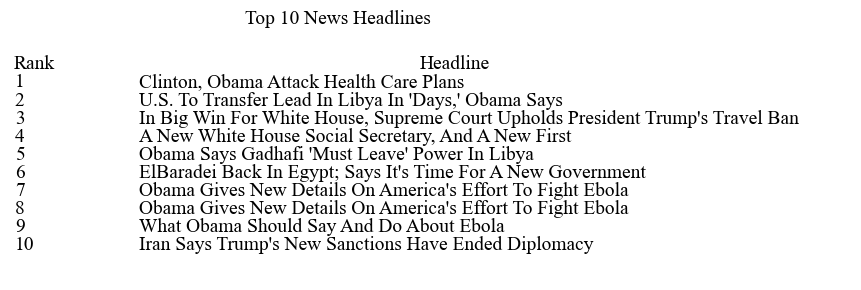

In [217]:
import matplotlib.pyplot as plt

def display_top_headlines_nyt_style(headlines, title="Top 10 News Headlines"):
    """
    Display a minimalist, data-driven table with minimal whitespace.
    
    :param headlines: List of headline strings (assumed sorted by importance).
    :param title:     Title for the table/figure.
    """

    # Prepare table data: each row is [rank, headline]
    table_data = [[str(i), headline] for i, headline in enumerate(headlines, start=1)]

    # Make the figure height scale a bit with the number of headlines
    # Adjust these multipliers as needed
    fig_height = 0.15 * len(headlines) + 1.5
    fig_width = 7  # narrower figure
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Remove axis lines and ticks
    ax.axis('off')
    
    # Create the table, letting matplotlib auto-size columns
    table = ax.table(
        cellText=table_data,
        colLabels=["Rank", "Headline"],
        loc='center',
        cellLoc='left'
    )
    
    # Auto-size columns to fit data
    table.auto_set_column_width(col=list(range(2)))
    
    # Control font size and remove any extra vertical scaling
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    # Style each cell
    for (row, col), cell in table.get_celld().items():
        # Remove borders
        cell.set_edgecolor('none')
        cell.set_linewidth(1)
        # White background
        cell.set_facecolor('white')
        
        if row == 0:
            # Header row: normal weight, align with data
            cell.set_text_props(fontweight='normal')
            cell._loc = 'right' if col == 0 else 'left'
        else:
            # Data rows: right-align rank
            if col == 0:
                cell._loc = 'right'
            else:
                cell._loc = 'left'

    # Title on the left with minimal padding
    ax.set_title(
        title,
        fontsize=14,
        fontweight='normal',
        loc='left',
        pad=4
    )
    
    plt.tight_layout()
    plt.show()

display_top_headlines_nyt_style(spacy_summary)

<h3 style="font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
           font-size: 1.25em;
           color: #000000;
           font-weight: bold;
           border-bottom: 1.5px solid #dcdcdc;
           margin-top: 20px;
           margin-bottom: 10px;
           padding-bottom: 5px;">
  Side-by-Side Comparison
</h3>

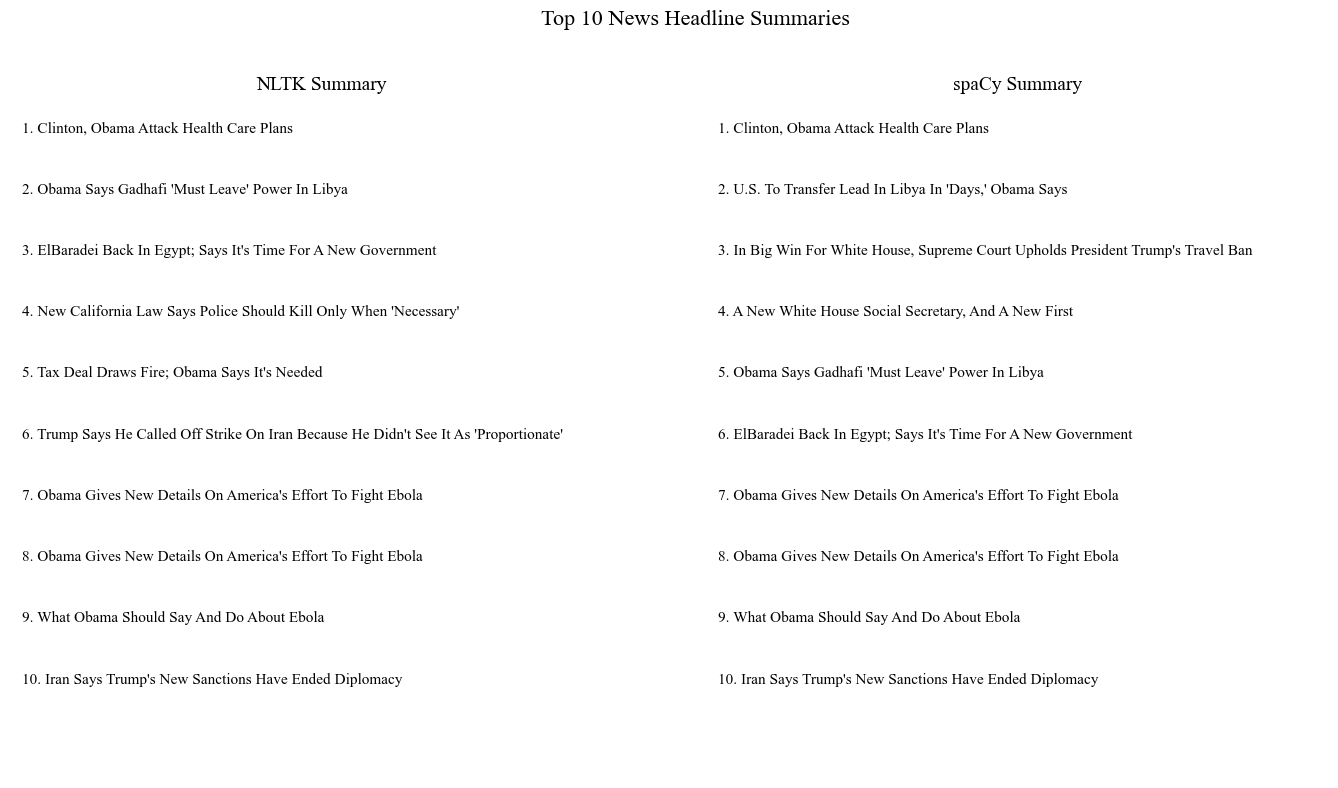

In [218]:
# Final Visualization: Side-by-Side Comparison of Summaries

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle("Top 10 News Headline Summaries", fontsize=16)

# Disable axis for a clean layout
for ax in axes:
    ax.axis('off')

# Left Panel: NLTK Summary
axes[0].set_title("NLTK Summary", fontsize=14)
for idx, sentence in enumerate(nltk_summary):
    axes[0].text(0.02, 0.95 - idx * 0.09, f"{idx+1}. {sentence}",
                 fontsize=11, transform=axes[0].transAxes)

# Right Panel: spaCy Summary
axes[1].set_title("spaCy Summary", fontsize=14)
for idx, sentence in enumerate(spacy_summary):
    axes[1].text(0.02, 0.95 - idx * 0.09, f"{idx+1}. {sentence}",
                 fontsize=11, transform=axes[1].transAxes)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
